In [2]:
import numpy as np

from dataset_loader import load_from_file
from tabulate import tabulate
from matplotlib.pyplot import figure, imshow, axis
from commons import *
from skimage import data, util
from skimage.measure import label, regionprops
from scipy.ndimage import rotate
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data
from skimage.transform import probabilistic_hough_line
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

# obrót do poziomu, metodami:
# 1. hough lines
# 2. tomkowe
# 3. tamtą pierwszą biblioteką od eliciticy
# informacja wzjaemna - między jednym obrazkiem a porównywanym
# jeszcze te metryki: https://towardsdatascience.com/measuring-similarity-in-two-images-using-python-b72233eb53c6


DOTS_DST = 'cache/dots_v2.pickle'
TRACKS_DST = 'cache/tracks_v2.pickle'
WORMS_DST = 'cache/worms_v2.pickle'
ARTIFACTS_DST = 'cache/artifacts_v2.pickle'

DOTS_DSTx4 = 'cache/dots_v3.pickle'
TRACKS_DSTx4 = 'cache/tracks_v3.pickle'
WORMS_DSTx4 = 'cache/worms_v3.pickle'
ARTIFACTS_DSTx4 = 'cache/artifacts_v3.pickle'


tf_classes = [ tf.keras.metrics.AUC,
    tf.keras.metrics.Accuracy,
    tf.keras.metrics.BinaryAccuracy,
    tf.keras.metrics.BinaryCrossentropy,
    tf.keras.metrics.BinaryIoU,
    tf.keras.metrics.CategoricalAccuracy,
    tf.keras.metrics.CategoricalCrossentropy,
    tf.keras.metrics.CategoricalHinge,
    tf.keras.metrics.CosineSimilarity,
    tf.keras.metrics.FalseNegatives,
    tf.keras.metrics.FalsePositives,
    tf.keras.metrics.Hinge,
    #tf.keras.metrics.IoU,
    tf.keras.metrics.KLDivergence,
    tf.keras.metrics.LogCoshError,
    tf.keras.metrics.Mean,
    tf.keras.metrics.MeanAbsoluteError,
    tf.keras.metrics.MeanAbsolutePercentageError,
    #tf.keras.metrics.MeanIoU,
    #tf.keras.metrics.MeanMetricWrapper,
    #tf.keras.metrics.MeanRelativeError,
    tf.keras.metrics.MeanSquaredError,
    tf.keras.metrics.MeanSquaredLogarithmicError,
    #tf.keras.metrics.MeanTensor,
    #tf.keras.metrics.Metric,
    #tf.keras.metrics.OneHotIoU,
    #tf.keras.metrics.OneHotMeanIoU,
    tf.keras.metrics.Poisson,
    tf.keras.metrics.Precision,
    #tf.keras.metrics.PrecisionAtRecall,
    tf.keras.metrics.Recall,
    #tf.keras.metrics.RecallAtPrecision,
    tf.keras.metrics.RootMeanSquaredError,
    #tf.keras.metrics.SensitivityAtSpecificity,
    tf.keras.metrics.SparseCategoricalAccuracy,
    tf.keras.metrics.SparseCategoricalCrossentropy,
    tf.keras.metrics.SparseTopKCategoricalAccuracy,
    #tf.keras.metrics.SpecificityAtSensitivity,
    tf.keras.metrics.SquaredHinge,
    tf.keras.metrics.Sum,
    tf.keras.metrics.TopKCategoricalAccuracy,
    tf.keras.metrics.TrueNegatives,
    tf.keras.metrics.TruePositives ]

def generic_tf_metrics(cls):
    def tf_metrics(image, recon):
        m = cls()
        m.update_state(image, recon)
        return m.result().numpy()
    return tf_metrics, cls.__name__

tf_mean = generic_tf_metrics(tf.keras.metrics.Mean)


def tf_kl_divergence(image, recon):
    m = tf.keras.metrics.KLDivergence()
    m.update_state(image, recon)
    return m.result().numpy()


def tf_accuracy(image, recon):
    m = tf.keras.metrics.Accuracy()
    m.update_state(image, recon)
    return m.result().numpy()

def tf_mse(image, recon):
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(image, recon)
    return m.result().numpy()




funcs = [
    (dm_func_mean2, 'mean'),
    (dm_func_avg_hash, 'avg_hash'),
    (dm_func_p_hash, 'p_hash'),
    (dm_func_d_hash,  'd_hash'),
    (dm_func_haar_hash,  'haar_hash'),
    (dm_func_db4_hash, 'db4_hash')
] #, tf_kl_divergence, tf_accuracy, tf_mse]
for c in tf_classes:
    funcs.append(generic_tf_metrics(c))


def angle(x, y):
    rad = np.arctan2(y, x)
    degrees = rad*180/np.pi
    return degrees


def round_normalize(image):

    #label_img = np.where(image > 0, 1, 0)
    #label_img = label(img, connectivity=img.ndim)
    #props = regionprops(label_img)

    #edges = canny(image, 2, 1, 25)
    lines = probabilistic_hough_line(image, threshold=10, line_length=5, line_gap=3)
    angles = []
    for l in lines:
        vector_1 = [l[1][1] - l[0][1], l[1][0] - l[0][0]]
        print(vector_1)
        angles.append(angle(l[1][0] - l[0][0], l[1][1] - l[0][1]))
    deg = np.average(angles) if len(angles) else 0
    print(deg)
    print("")

    mask = np.where(image == 0, 0.0, 1.0)
    rotated_mask = rotate(mask, deg, reshape=False)
    rotated_image = rotate(image, deg, reshape=False)
    rotated_image = np.where(rotated_mask < 0.25, 0, rotated_image)
    rotated_image = np.where(rotated_image < 0, 0, rotated_image)
    rotated_image = np.where(rotated_image > 1, 1, rotated_image)
    rotated_image.sort(axis=0)
    rotated_image.sort(axis=1)
    return rotated_image


def showImagesMatrix(images, col=10):

    hSize = 20
    wSize = 20

    fig = figure( figsize=(wSize, hSize))
    number_of_files = len(images)
    row = number_of_files // col
    if (number_of_files%col != 0):
        row += 1

    row_head = ['Image 0 vs image:']
    row_funcs = []

    for f, n in funcs:
        row_funcs.append([n])

    img0 = round_normalize(images[0])
    img0 = np.expand_dims(img0, axis=-1)

    for i in range(number_of_files):
        row_head.append(str(i))
        a=fig.add_subplot(row,col,i+1)
        image = round_normalize(images[i])
        image = np.expand_dims(image, axis=-1)
        imshow(image,cmap='Greys_r')
        axis('off')

        #print('%010s | %6.3f' % ('dm_func_mean2', v))
        for fi, (f, n) in enumerate(funcs):
            v = f(img0, image)
            row_funcs[fi].append(str(v))

    table = [row_head, *row_funcs]
    print(tabulate(table))



images, augmented = load_from_file(TRACKS_DST)
#showImagesMatrix([augmented[16], augmented[0], augmented[2], augmented[5], images[0]], 5)
#showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

[-8, -8]
[-7, -7]
-135.0

[-8, -8]
[-5, -5]
-135.0

[-4, -10]
[-2, -6]
[-2, -5]
-159.32074406812478

[-8, 8]
[-7, 7]
-45.0

[-8, -8]
[-7, -7]
-135.0

[-7, 7]
[-8, 8]
-45.0

-----------------------------  -------------  ---------------  -------------  -------------  -------------
Image 0 vs image:                 0               1               2              3              4
mean                              0             -12.5265          0              0              0
avg_hash                          0               0               0              0              0
p_hash                            0               0               0              0              0
d_hash                            0               0               0              0              0
haar_hash                         0               0.00756144      0              0              0
db4_hash                          0               0               0              0              0
AUC                               

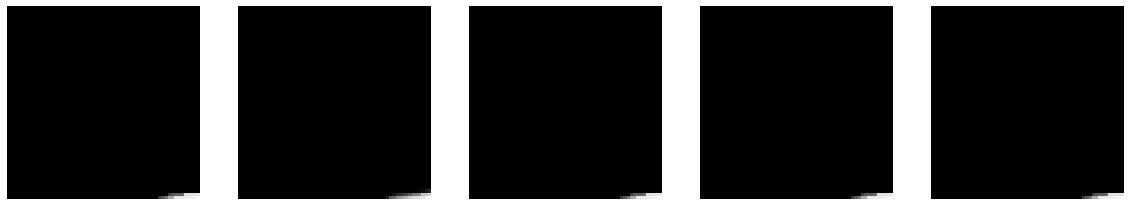

In [3]:
showImagesMatrix([images[0], augmented[0], augmented[2], augmented[5], augmented[16]], 5)

[-8, -8]
[-7, -7]
-135.0

[-8, -8]
[-7, -7]
-135.0

[-8, -3]
-110.55604521958347

[-4, -7]
-150.25511870305778

[-5, -5]
[-6, -6]
-135.0

[-11, -1]
-95.19442890773482

-----------------------------  -------------  ---------------  ---------------  ---------------  ---------------
Image 0 vs image:                 0               1                2                3                4
mean                              0             -11.2969         -10.6852         -10.3965          -9.88965
avg_hash                          0               0                0                0.00189036       0
p_hash                            0               0                0                0                0
d_hash                            0               0                0                0.00189036       0
haar_hash                         0               0.00756144       0.0151229        0.0226843        0.0226843
db4_hash                          0               0.0453686        0.0642722        0.0

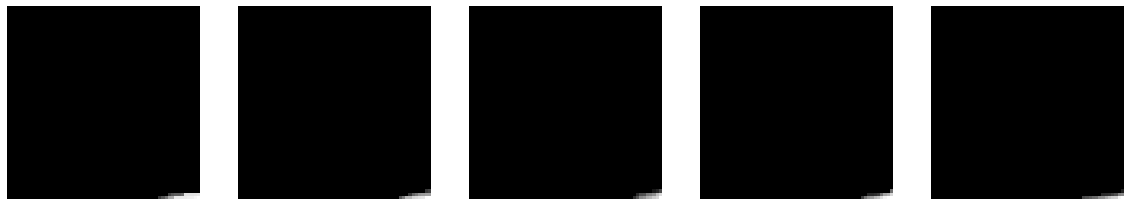

In [4]:
showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

0

0

0

0

0

0

-----------------------------  --------------  ---------------  ---------------  --------------  --------------
Image 0 vs image:                 0                1                2               3               4
mean                              0               -6.53412         -8.28382         0               0
avg_hash                          0                0                0               0               0
p_hash                            0                0                0               0               0
d_hash                            0                0                0               0               0
haar_hash                         0                1                0               0               0
db4_hash                          0                0                0               0               0
AUC                               1                1                0.749931        1               1
Accuracy                          1                0.9

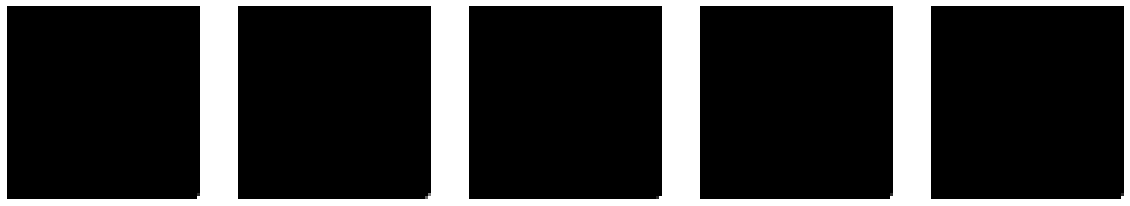

In [5]:
images_dots, augmented_dots = load_from_file(DOTS_DST)

showImagesMatrix([images_dots[0], augmented_dots[0], augmented_dots[2], augmented_dots[5], augmented_dots[16]], 5)

0

0

0

0

0

0

-----------------------------  --------------  ----------------  ----------------  ----------------  ----------------
Image 0 vs image:                 0                 1                 2                 3                 4
mean                              0                -3.55451          -4.05199          -1.53336          -1.69392
avg_hash                          0                 0                 0                 0                 0
p_hash                            0                 0                 0                 0                 0
d_hash                            0                 0                 0                 0                 0
haar_hash                         0                 3                 0                 3                 3
db4_hash                          0                 0                 2.25              0                 2.5
AUC                               1                 0.999861          0.999861          0.999861    

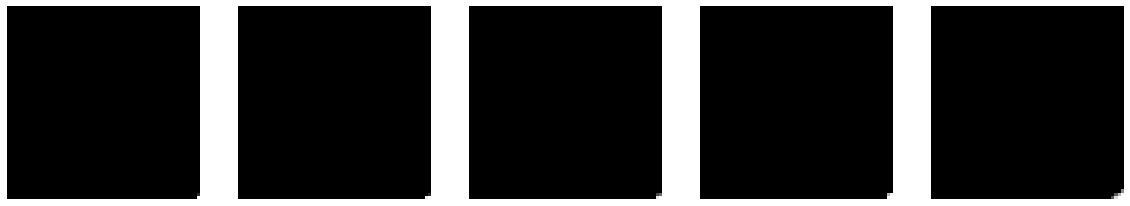

In [6]:
showImagesMatrix([images_dots[0], images_dots[1], images_dots[2], images_dots[3], images_dots[4]], 5)

[-3, -6]
[-3, -6]
[-5, 5]
-117.28996588194802

[-7, -2]
[-5, -5]
[-5, -2]
[-5, 5]
[-5, -5]
[-5, 5]
-96.29113423121244

[-5, -5]
[-5, -5]
[-5, -5]
[-5, -5]
[-5, -5]
[-5, -5]
[-5, 5]
-122.14285714285714

[-5, -5]
[-5, -5]
[-5, -5]
[-5, 5]
-112.5

[-5, -5]
[-5, 2]
[-5, 5]
[-6, -3]
[-5, 5]
-81.95272833814523

[-5, -5]
[-5, -5]
[-5, -5]
[-5, 5]
[-2, 7]
-93.18907918018456

-----------------------------  ---------------  ---------------  --------------  --------------  ---------------
Image 0 vs image:                  0                1               2               3                4
mean                             -16.3769         -16.356         -17.2471        -17.4688         -16.6098
avg_hash                           0                0               0               0                0
p_hash                             0                0               0               0                0
d_hash                             0                0               0               0               

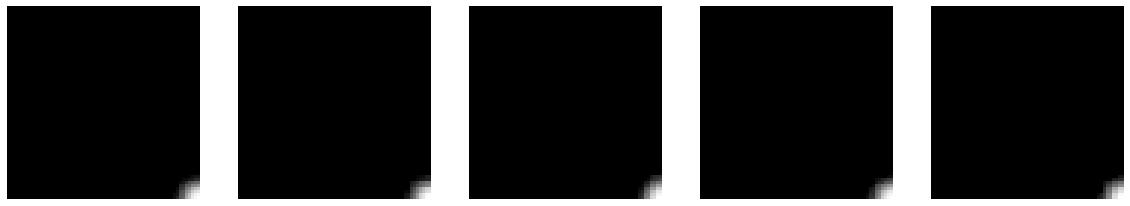

In [7]:
images_dots4x, augmented_dots4x = load_from_file(DOTS_DSTx4)
showImagesMatrix([images_dots4x[0], augmented_dots4x[0], augmented_dots4x[2], augmented_dots4x[5], augmented_dots4x[16]], 5)

[-3, -6]
[-5, -5]
-144.217474411461

[-7, -2]
[-5, 5]
[-3, -6]
[-3, -6]
[-7, 2]
[-5, -2]
-107.2785511886993

[-5, -5]
[-6, -3]
[-6, -6]
[-3, 9]
[-3, -7]
[-2, 5]
[-3, -5]
[-5, -3]
[0, -8]
-74.84475766363374

[-8, -4]
[-4, 9]
[-3, 6]
[-7, 6]
[-3, -8]
[-7, -7]
[-6, 6]
[-6, -6]
[-6, -7]
[-3, -5]
-97.93702002870683

[-8, 8]
[-10, 4]
[-2, 10]
[-8, 5]
[-7, 4]
[-8, -8]
[-2, 10]
[-7, -7]
[-9, 8]
[-5, 5]
[-3, -5]
[-5, -5]
[-3, 7]
[-8, 4]
-70.57888817318496

[-12, 12]
[-13, 6]
[-8, 13]
[-10, 7]
[-8, 8]
[-6, 7]
[-11, -4]
[-6, -6]
[-10, 5]
[-2, 8]
[-2, 6]
[-10, 6]
[-11, 7]
[-5, 2]
[-7, 7]
[-8, 8]
[-8, 7]
[-6, 6]
-55.10603334914166

-----------------------------  --------------  ----------------  ----------------  --------------  --------------
Image 0 vs image:                 0                 1                 2               3               4
mean                            -16.1255          -10.6598          -11.1425         -7.66971        -7.71381
avg_hash                          0          

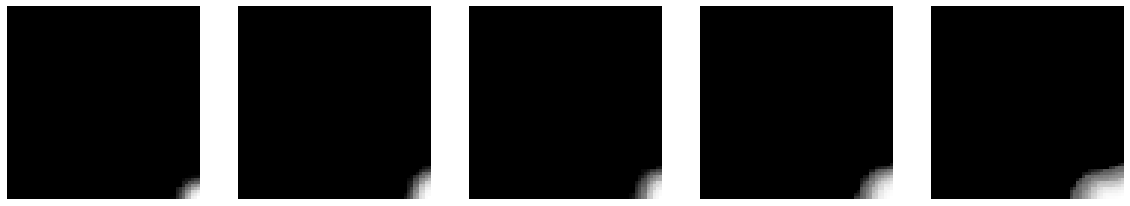

In [8]:
showImagesMatrix([images_dots4x[0], images_dots4x[1], images_dots4x[2], images_dots4x[3], images_dots4x[4]], 5)

[-3, 7]
[-5, 5]
-34.09929525682409

[-3, 7]
[-5, 5]
-34.09929525682409

[-7, 3]
-66.80140948635182

[-5, -5]
[-5, -5]
-135.0

[-6, 5]
[-4, 7]
-39.96965510233852

[-5, -5]
[-5, -5]
-135.0

-----------------------------  -------------  ---------------  ---------------  ---------------  ---------------
Image 0 vs image:                 0               1                2                3                4
mean                              0             -15.3827         -14.5796         -15.2529         -14.5796
avg_hash                          0               0                0                0                0
p_hash                            0               0                0                0                0
d_hash                            0               0                0                0                0
haar_hash                         0               0.0135276        0.00104058       0.00936524       0.00104058
db4_hash                          0               0                

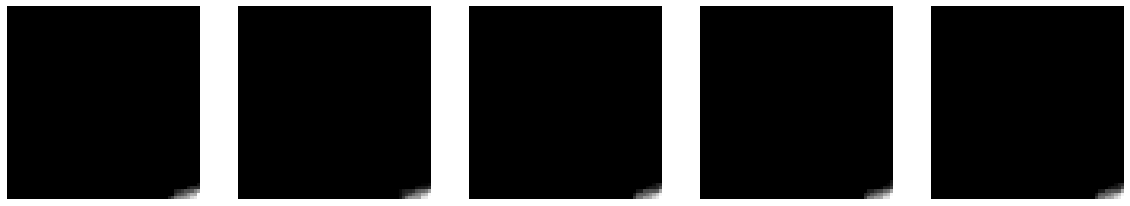

In [9]:
images_worms, augmented_worms = load_from_file(WORMS_DST)
showImagesMatrix([images_worms[0], augmented_worms[0], augmented_worms[2], augmented_worms[5], augmented_worms[16]], 5)

[-3, 7]
[-5, 5]
-34.09929525682409

[-5, 5]
-45.0

[-3, -5]
-149.03624346792648

[-9, 7]
[-7, 5]
[-3, 6]
[-6, 5]
-45.83670466043505

0

0

-----------------------------  ---------------  --------------  --------------  ----------------  ----------------
Image 0 vs image:                  0               1               2                 3                 4
mean                             -14.5796        -11.4344         -7.69458          -8.9812           -7.8688
avg_hash                           0               0.00104058      0.00208117        0.00312175        0.00208117
p_hash                             0               0               0                 0                 0
d_hash                             0               0               0.00312175        0.00208117        0.00208117
haar_hash                          0.00104058      0.00520291      0.00936524        0.00520291        0.00520291
db4_hash                           0               0.00728408      0.0416233        

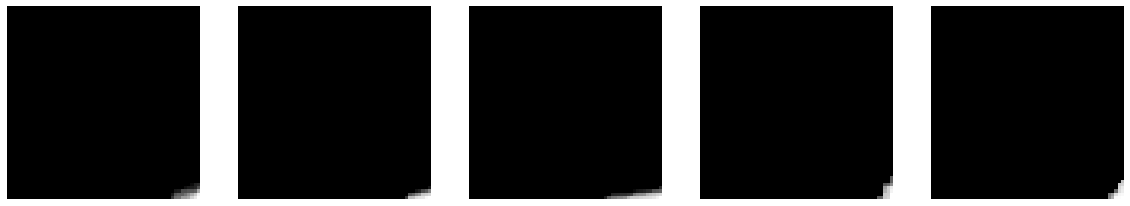

In [10]:
showImagesMatrix([images_worms[0], images_worms[1], images_worms[2], images_worms[3], images_worms[4]], 5)

[-8, -8]
[-7, -7]
-135.0

[-8, -8]
[-7, -7]
-135.0

[-2, 5]
-21.80140948635181

0

[-5, 5]
[-5, 5]
[-8, -1]
[-2, -7]
[-5, -5]
[-7, -1]
-97.3849538003558

-----------------------------  -------------  ----------------  --------------  --------------
Image 0 vs image:                 0                1               2               3
mean                              0               -9.7946         -8.085          -8.08023
avg_hash                          0                0               0.00378072      0.00378072
p_hash                            0                0               0               0
d_hash                            0                0               0.00378072      0.00189036
haar_hash                         0                0               0               0.0226843
db4_hash                          0                0.0453686       0.0359168       0.073724
AUC                               1                0.955592        0.543478        0.887488
Accuracy                 

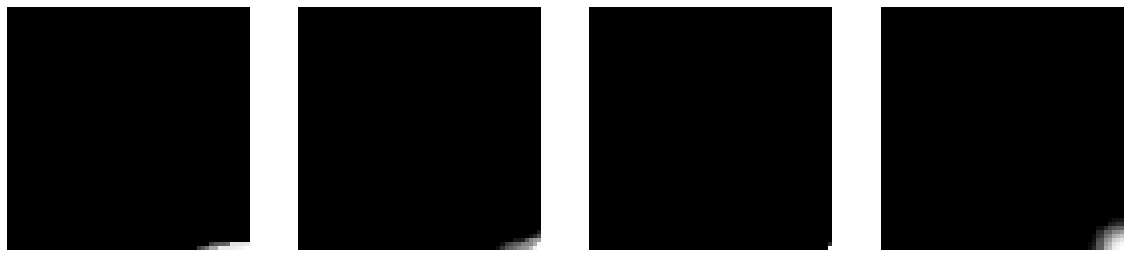

In [11]:
showImagesMatrix([images[0], images_worms[0], images_dots[0], images_dots4x[0][2:62,2:62]], 4)